In [2]:
pwd

'/home/johan/nf/nf-rtime/Projects_Templates/8_Replay_BWII'

In [3]:
# import all the needed stuff:

import ipdb
import time
import sys
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import easygui  # popup windows with buttons made easy
import mne  # EEGLAB for python
from IPython.display import clear_output  # to clear the cell output during while loop
import re  # regular expressions
import pickle  # to save/load data
import dynarray  # a growing numpy array

import importlib

import logging
logging.basicConfig(level=logging.ERROR)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra

sys.path.append("../../callpyff")   # talk to the stimuli
from callpyff import bcinetwork, bcixml 


sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc
from wyrm import signaltracking
from wyrm import filtering

import scipy
from scipy import signal

from collections import deque  # a FILO list useful for plotting!

# getting rid of the annoying warnings!
import importlib
import warnings
warnings.filterwarnings('ignore')


# import also the stuff we need from pynfb Russian Guys
sys.path.append("../../wyrm")  # real-time data analysis

sys.path.append("../../../nfb")
sys.path.append("../../../nfb/pynfb")

# import os
# sys.path.append(sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))

ModuleNotFoundError: No module named 'nftools.loopcontrol'

In [10]:
sys.path

['/home/rt/miniconda2/envs/rt/lib/python36.zip',
 '/home/rt/miniconda2/envs/rt/lib/python3.6',
 '/home/rt/miniconda2/envs/rt/lib/python3.6/lib-dynload',
 '',
 '/home/rt/miniconda2/envs/rt/lib/python3.6/site-packages',
 '/home/rt/miniconda2/envs/rt/lib/python3.6/site-packages/IPython/extensions',
 '/home/rt/.ipython',
 '../../mushu',
 '../../mushu/libmushu',
 '../../nftools',
 '../../callpyff',
 '../../wyrm',
 '..',
 '../../wyrm',
 '../../../nfb/pynfb',
 '../../mushu',
 '../../mushu/libmushu',
 '../../nftools',
 '../../callpyff',
 '../../wyrm',
 '../../wyrm',
 '../../../nfb/pynfb',
 '../../mushu',
 '../../mushu/libmushu',
 '../../nftools',
 '../../callpyff',
 '../../wyrm',
 '../../wyrm',
 '../../../nfb/pynfb',
 '../../mushu',
 '../../mushu/libmushu',
 '../../nftools',
 '../../callpyff',
 '../../wyrm',
 '../../wyrm',
 '../../../nfb/pynfb',
 '../../mushu',
 '../../mushu/libmushu',
 '../../nftools',
 '../../callpyff',
 '../../wyrm',
 '../../wyrm',
 '../../../nfb/pynfb',
 '../../mushu',
 '.

In [11]:
import widgets

In [12]:
from widgets.signal_viewers import RawSignalViewer

In [42]:
raw_fromfile.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, Cz, C4, P3, Pz, ...
    chs : list | 13 items (EEG: 13)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 16 items (3 Cardinal, 13 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 500.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 13
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneTyp

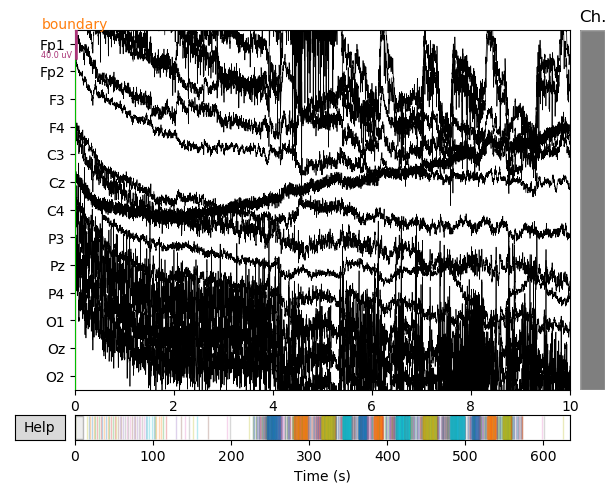

Attempting to create new mne-python configuration file:
/home/rt/.mne/mne-python.json


In [40]:
raw_fromfile.plot()

In [14]:
# so grab some data for replay:

# fn=easygui.fileopenbox(default='/home/johan/nf/')
# print(fn)

fn='/home/rt/nf/example-data.set'
raw_fromfile = mne.io.read_raw_eeglab(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)


# properties of the recording, and what we're doing here:
fs = raw_fromfile.info['sfreq']
nbchan = raw_fromfile.info['nchan']-1

updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data

In [15]:
%matplotlib qt

In [16]:
# prepare data for replay (warning: need probably a lot of memory)

mul_factor = 1.0
if 1e-6 in [raw_fromfile.info['chs'][0]['cal'], raw_fromfile.info['chs'][0]['range']]:
    mul_factor = 1.0 / 1e-6

seed_d=raw_fromfile[:-1,:][0] * mul_factor  # scale the data to seed (so no 1e-6 stuff in the replayed data)
seed_d=np.array(seed_d.transpose())
seed_ch=raw_fromfile.ch_names[0:-1]
seed_fs=raw_fromfile.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw_fromfile[-1,:][0])
seed_m=[[i / raw_fromfile.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [17]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=10)

In [18]:
# for collecting the data again after replay:
alld=dynarray.DynamicArray((None, 2))     # data
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

markTime=time.time()


rb = RingBuffer(buffSize * 1000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

# PUTTING ON THE EEG CAP


## The following should likely be put into something more convenient like a class, or using wyrm's functionality

In [19]:
%matplotlib qt5  
plt.ion()  # enable widget plots & interactive plots

time_in_plot=10.0
sy1=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list
sy2=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list
sy3=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list
sy4=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list

channel_to_plot=0
sx = np.linspace(0, time_in_plot, round(fs * time_in_plot))

featuresy1 = deque(np.zeros(round(1/updateTime * time_in_plot)), round(1/updateTime * time_in_plot))
featuresx = np.linspace(0, time_in_plot, round(1/updateTime * time_in_plot))


In [20]:
bcinet = bcinetwork.BciNetwork('127.0.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [9]:
feedbacks = bcinet.getAvailableFeedbacks()
print(feedbacks)

['TestD2', 'MovingRhomb', 'LibetClock', 'BrainWaveTraining_II', 'TobiQLAdapter', 'EyetrackerRawdata', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'StopVigilanceTask', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'VisualOddball', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'RestingState', 'NFBasicThermometer', 'RSVPSpeller', 'EEGfMRILocalizer', 'Oddball', 'Lesson01b', 'GoalKeeper', 'CenterSpellerVE', 'MultiVisualOddball', 'StroopFeedback', 'ERPMatrix', 'Lesson04', 'Lesson05', 'Lesson06', 'Lesson01', 'Lesson02', 'Lesson03', 'VisualOddballVE']


In [10]:
bcinet.send_init('BrainWaveTraining_II')

In [11]:
print(len(bcinet.get_variables()))

89


In [12]:
bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))

In [13]:
bcinet.play()

In [14]:
bcinet.send_signal(bcixml.BciSignal({'emgThrContainer': 0.1}, None, bcixml.CONTROL_SIGNAL))

In [21]:
importlib.reload(signaltracking)

# from wyrm import signaltracking
eegfilter = filtering.bwBPF(12,15)
emgfilter = filtering.bwHPF(50)
# smoother = filtering.bwExponentialSmoother(0.998)
# smoother = filtering.bwLPF(2,order=2)
smoother_eeg = filtering.bwSimpleAverager(300,2)
smoother_emg = filtering.bwSimpleAverager(300,2)

track_for_eeg_stimuli = signaltracking.sending_to_nfstim(thr=1.0, dur=0.20, feedback_type='eeg', max4audio=1.2, bcinet=bcinet, st_scaling=10)
track_for_emg_stimuli = signaltracking.sending_to_nfstim(thr=10, dur=0.15, feedback_type='emg', bcinet=bcinet, st_scaling=30)

bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f': 2}
thr: 1.00, dur: 0.20
bcinet is passed on
thr: 10.00, dur: 0.15
bcinet is passed on


### until here

## Staring up the Stimulation

In [22]:
sent=[]

In [23]:
dts=[]

In [24]:
amp.start()

In [25]:
fig=plt.figure()  # plotting...
th=fig.suptitle('')
ah1=fig.add_subplot(111)
# ah2=fig.add_subplot(122)
l1, = ah1.plot(sx, sy1)
l2, = ah1.plot(sx, sy2)
l3, = ah1.plot(sx, sy3)
l4, = ah1.plot(sx, sy4)
thrline = ah1.plot(ah1.get_xlim(), [1, 1])

# featurefig = plt.figure()
# featureth=featurefig.suptitle('')
# featureah=featurefig.add_subplot(111)
# featurel1, = featureah.plot(featuresx, featuresy1)
amp.get_data()


# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker = amp.get_data()
    
    if data.shape[0] > 0:  # this is crucual for remembering filter state.
        
        
        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
        
        # preprocessing stream for EEG
        eeg_cnt = proc.select_channels(cnt, ['C3','C4'])
        f_eeg_cnt = eegfilter.apply(eeg_cnt)  # so filter it according to specified above
        af_eeg_cnt = proc.absolute(f_eeg_cnt)
        saf_eeg_cnt = smoother_eeg.apply(af_eeg_cnt)
        
        dts.append(saf_eeg_cnt.data.shape[0])
        
        # communications with the st-stim computer
        tf, audioTF = track_for_eeg_stimuli.check_above_threshold(saf_eeg_cnt)  # sends markers (should be fast)
        s = track_for_eeg_stimuli.send_data_signal(saf_eeg_cnt) # sends the signal (should also be fast!)
        sent.append(s)

        
        # do the EMG:
        emg_cnt = proc.select_channels(cnt, ['O1','O2'])
        f_emg_cnt = emgfilter.apply(emg_cnt)  # so filter it according to specified above
        af_emg_cnt = proc.absolute(f_emg_cnt)
        saf_emg_cnt = smoother_emg.apply(af_emg_cnt)
        
        tfemg, audioTFemg = track_for_emg_stimuli.check_above_threshold(saf_emg_cnt)  # sends markers (should be fast)
        semg = track_for_emg_stimuli.send_data_signal(saf_emg_cnt) # sends the signal (should also be fast!)
        
        # track_for_emg_stimuli.check_rising(af_emg_cnt)
        # f_cnt = f_eeg_cnt
        
        
        alld.extend(eeg_cnt.data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += cnt.data.shape[0] / float(sfreq) * 1000.
        

        # plotting...
        sy1.extend(np.mean(af_eeg_cnt.data,1))  # to visualize/plot -- s1 and s2 are deque's
        sy2.extend(np.mean(saf_eeg_cnt.data,1))
        sy3.extend(tf*2) 
        sy4.extend(audioTF)
        l1.set_ydata(sy1)
        l2.set_ydata(sy2)
        l3.set_ydata(sy3)
        l4.set_ydata(sy4)
        msy1=np.mean(sy1)
        msy2=np.mean(sy2)
        ah1.set_ylim(-2, 10)
        # ah2.set_ylim(-20+msy2, 20+msy2)

        fig.canvas.draw()
        fig.canvas.flush_events()

        
        

        # append to ringbuffer, so we can calculate features later on on the last N secs/samples of data.
        rb.append(f_eeg_cnt)



        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:
            # do Stuff

            markTime = curTime
            # 1) obtain last 1-second(s)
            # d = rb.get()

            # thomas does stuff here - in this example, we take channel 3 of the data and filter it
            # feature = np.log10(np.mean(abs(d.data[:,0]))) * 10
            # featuresy1.append(feature)


            # we send the value to BCI/STIM here - but not right now
            # bcinet.send_signal(bcixml.BciSignal({'nfsignal': signalToSend},None, bcixml.CONTROL_SIGNAL))
            # featureMax = 0
            # featureMin = -6.0
            # featureScaling = 1/abs(featureMax - featureMin)
            # featureOffset = (featureMax + featureMin) / 2
            # signalToSend = featureScaling * (feature - featureOffset)

            # plot of the feature in a separate figure, to keep track:
            # featurel1.set_ydata(featuresy1) # plotting the feature stuff
            # featuremsy1=np.mean(featuresy1)
            # featureah.set_ylim(-10+featuremsy1, 10+featuremsy1)
            # featurefig.canvas.draw()
            # featurefig.canvas.flush_events()
            

            # clear_output(wait=True)  # write some logging information here
            # clear_output clear the output of the cell, but if you do that you also remove the figures, it seems
            # so don't do it!
            str1 = 'Playing Back - time = %f' % (curTime - t0)
            str2 = 'Length Markers: %d' % len(allm)
            str3 = '%d, %d' % data.shape
            # str4 = 'Feature Value: %f' % feature
            # str5 = 'Scaled Signal for NF: %f' % signalToSend
            #print(str1 + '\n' + str2 + '\n' + str3 + '\n' + str4 + '\n' + str5)
            
            # print('Length Markers: %d' % len(allm))
            # print(data.shape)
            th.set_text(str1 + '\n' + str2 + '\n' +str3)
            # featureth.set_text(str4 + '\n' + str5)





sending signal -- I ! - 40 - 3 - True - -1
sending signal! - 3 False - 14.693646306181629 -- 0.2
sending signal -- I ! - 80 - 4 - True - -1
sending signal! - 6 False - 18.337042470382144 -- 0.25
sending signal! - 7 False - 27.752615241741005 -- 0.25
sending signal! - 8 False - 39.24511861619093 -- 0.3
sending signal! - 9 False - 29.15790531142606 -- 0.3
sending signal! - 11 False - 43.63423221191293 -- 0.35
sending signal! - 13 False - 30.68127911217476 -- 0.35
sending signal! - 15 False - 44.71432272147202 -- 0.39999999999999997
sending signal -- I ! - 310 - 15 - True - -1
sending signal! - 15 False - 0.2570167565490595 -- 0.2
sending signal! - 16 False - 44.854751610234345 -- 0.44999999999999996
sending signal -- I ! - 40 - 20 - True - -1
sending signal! - 20 False - 0.387901708666429 -- 0.2
sending signal -- I ! - 70 - 22 - True - -1
sending signal! - 22 False - 0.10641676429775211 -- 0.25
sending signal! - 23 False - 1.0132943009129263 -- 0.25
sending signal! - 27 False - 0.1687239

KeyboardInterrupt: 

sending signal -- I ! - 70 - 4447 - True - -1
sending signal! - 4447 False - 0.012128967524522546 -- 0.25
sending signal! - 4450 False - 0.01937424340328262 -- 0.3
sending signal -- I ! - 60 - 4466 - True - -1
sending signal! - 4466 False - 0.06279386456569248 -- 0.25
sending signal -- I ! - 150 - 4495 - True - -1
sending signal! - 4496 False - 0.09181096797381057 -- 0.25


KeyboardInterrupt: 

In [26]:
amp.stop()

amplifier stopped!


In [27]:
(track_for_eeg_stimuli.thr / track_for_eeg_stimuli._st_scaling) + track_for_eeg_stimuli._st_offset

-0.44999999999999996

In [28]:
track_for_eeg_stimuli.thr

1.0

In [29]:
track_for_emg_stimuli.dur

0.15

In [30]:
plt.figure()
plt.plot(sent[-1000:])
plt.ylim([-1, 1])

(-1, 1)

In [31]:
bcinet.send_signal(bcixml.BciSignal({'nfsignalContainer': 1.2}, None, bcixml.CONTROL_SIGNAL))

In [32]:
plt.figure()
plt.plot(dts)

In [33]:
np.array(sent)

array([None, None, None, ..., None, None, None], dtype=object)

In [34]:
bcinet.stop()

In [35]:
bcinet.quit()

In [36]:
af_eeg_cnt.axes

[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69.]), array(['C3', 'C4'], dtype='<U3')]

In [ ]:
bcinet = bcinetwork.BciNetwork('127.0.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [ ]:
feedbacks = bcinet.getAvailableFeedbacks()
print(feedbacks)

In [ ]:
bcinet.send_init('BrainWaveTraining_II')

In [ ]:
bcinet.get_variables()

In [ ]:
bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))

In [ ]:
bcinet.play()

In [14]:
ah1.get_xlim()

(-0.5, 10.5)

In [37]:
cnt.data.copy()

array([[-10595.37597656, -19478.03710938,  -8404.61621094,
        -10837.97460938,  -2991.59301758,  -5923.54980469,
         -4674.99853516, -12094.72753906,  -7886.17041016,
         -4090.45996094, -10324.00878906,  -4852.71337891],
       [-10598.68164062, -19480.49609375,  -8407.99316406,
        -10838.75976562,  -2993.34643555,  -5922.86816406,
         -4676.3984375 , -12094.79785156,  -7885.58251953,
         -4091.4609375 , -10324.80371094,  -4859.93408203],
       [-10599.62890625, -19483.3203125 ,  -8406.87988281,
        -10840.73730469,  -2993.21459961,  -5918.95068359,
         -4674.11523438, -12096.32421875,  -7886.53759766,
         -4091.86328125, -10329.95996094,  -4869.18212891],
       [-10599.59765625, -19486.60351562,  -8407.90429688,
        -10844.40234375,  -2993.92138672,  -5916.93017578,
         -4673.80566406, -12098.40039062,  -7886.19921875,
         -4093.24731445, -10333.48925781,  -4871.97558594],
       [-10602.57910156, -19489.15625   ,  -8407.981

In [15]:
plt.figure;plt.plot(af_eeg_cnt.data)

In [11]:
af_eeg_cnt

In [14]:
plt.figure()
plt.plot(smoother.b)

In [15]:
eeg_cnt.data.shape

(500, 2)

In [35]:
plt.figure()
plt.plot(proc.absolute(f_eeg_cnt).data)

In [16]:
eegfilter.b

array([ 8.21609743e-07,  0.00000000e+00, -2.46482923e-06,  0.00000000e+00,
        2.46482923e-06,  0.00000000e+00, -8.21609743e-07])

In [2]:
smoother.zi

NameError: name 'smoother' is not defined

In [10]:
alld.shrink_to_fit()

In [22]:
v=alld[:,0]

In [23]:
plt.figure()

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(smoother.b)

In [25]:
zi = signal.lfilter_zi(smoother.b, 1.0)

In [26]:
plt.figure();plt.plot(smoother.zi)

In [14]:
fv=signal.lfilter(smoother.b, 1.0, v, axis=0)

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [15]:
plt.plot(fv)

In [17]:
plt.figure()
plt.plot(smoother.zi)

In [18]:
zi=signal.lfiltic(smoother.b, 1.0, y=np.random.random((10,4)), x=np.random.random((10,4)))

ValueError: all the input arrays must have same number of dimensions

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from scipy import signal

In [ ]:
%matplotlib qt

In [31]:
for i, v in enumerate(cnt.data.copy()):
    print(v)
    print(i)

[ -8949.09570312 -17578.02539062  -6526.35742187 -10147.28222656
  -1737.39587402  -4909.40820312  -3469.99487305 -10258.97363281
  -6125.62939453  -2623.55981445  -8521.0625      -3356.83251953
  -3753.22412109]
0
[ -8956.48925781 -17584.65820312  -6528.56982422 -10145.55859375
  -1737.18457031  -4907.89794922  -3468.47094727 -10258.84082031
  -6125.64453125  -2621.71728516  -8518.42480469  -3350.35400391
  -3753.09130859]
1
[ -8970.42675781 -17585.85546875  -6532.98193359 -10149.93945312
  -1740.54101562  -4908.6640625   -3469.00561523 -10258.67578125
  -6124.03662109  -2615.64990234  -8509.91699219  -3336.71240234
  -3739.31835938]
2
[ -8974.49511719 -17583.96484375  -6533.07324219 -10150.15429688
  -1742.06689453  -4907.86572266  -3468.078125   -10259.75
  -6124.39697266  -2611.15576172  -8521.63574219  -3331.03588867
  -3743.26269531]
3
[ -8966.19726562 -17577.76171875  -6527.78759766 -10144.63964844
  -1740.65393066  -4906.92041016  -3467.98681641 -10263.26757812
  -6124.01269531

In [ ]:
b=signal.firwin(300,2*3/1000)

In [ ]:
zi = signal.lfilter_zi(b, 1)

In [ ]:
plt.plot(b)

In [ ]:
plt.show()

In [ ]:
d.units

In [ ]:
f_cnt.data.shape

In [ ]:
import signal

In [ ]:
from scipy import signal

In [ ]:
from scipy.signal import lfilter_zi